#  LMS Exploration | 19. Segmentation_map
---


**[Introduce]** 
- cityscapes dataset을 이용해 Pix2Pix를 학습시킵니다.
- image segmentation이 적용된 이미지를 Pix2Pix 모델에 입력하여 black-box에서 촬영된 실제 이미지를 생성하는 것이 목표입니다. 
- 프로젝트 요구사항
    1. 데이터에 한가지 이상의 augmentation을 적용합니다.
    2. skip connection이 있는 U-Net Generator를 사용합니다.
    3. 모델 학습 후, 학습된 Generator를 'val' 폴더 내에 있는 테스트 이미지로 평가합니다. 
    4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후에, 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화합니다. 
    5. 10 epoch 이상 학습하면서, 중간 손실 값에 대한 로그를 남깁니다. 

**[dataset]**
- 1000개의 학습용 이미지와 5개의 평가 이미지로 구성되어 있습니다. 

|평가문항|상세기준|자가진단|
|--|--|--|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.||
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.||
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.||

---

# 0. Pix2Pix 이해하기
- [Pix2Pix : Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf)는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, **이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델**입니다. 
- Conditional Adversarial Networks로 Image-to-Image Translation을 수행합니다.
- Conditional Adversarial Networks는 cGAN과 같은 구조를 말하고, Image-to-Image Translation은 이미지 간 변환을 의미합니다. 
- **한 이미지의 픽셀에서 다른 이미지의 픽셀로 (pixel to pixel) 변환**한다는 뜻에서 **Pix2Pix**라는 이름으로 불립니다. 이 구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구입니다. 
- 노이즈와 레이블 정보를 함꼐 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 **convolution 레이어**를 활용합니다. 또한 GAN 구조를 기반으로 하기 때문에 크게 **Generator와 Discriminator 두 가지 구성 요소**로 이뤄집니다. 
## Generator(U-Net)
- Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용됩니다.
- 여기서 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 이러한 문제에서 흔히 사용되는 구조는 Encoder-Decoder구조입니다. 
- Encoder에서 입력 이미지(x)를 받으면 단계적으로 이미지를 down-sampling하면서 입력 이미지의 중요한 representation을 학습하고, Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling 하여 입력 이미지와 동일한 크기의 변환된 이미지(y)를 생성해냅니다. 이러한 과정은 모두 convolution 레이어로 진행되며,레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 합니다. 이때, bottleneck이라고도 불리는 Encoder의 최종 출력은 입력 이미지(x)의 가장 중요한 특징만을 담고 있습니다. 
- 중요하지만 작은 특징이 변환된 이미지를 생성하는데 충분한 이미지를 제공하기는 어렵기 때문에, 논문에서는 **U-Net** 구조입니다. 
- 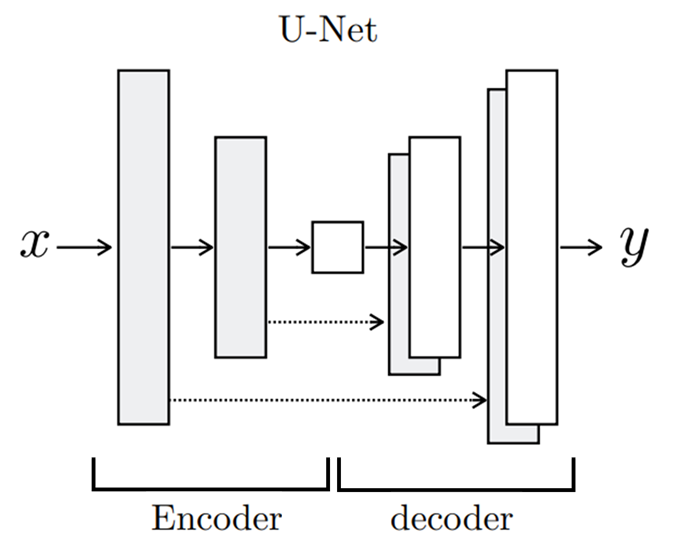
- U-Net은 단순한 Encoder-Decoder 구조의 Generator와 달리, 각 **레이어마다 Encoder와 Decoder가 연결(skip connection)**되어있습니다. 
- 이러한 구조는 Decoder가 변환된 이미지를 더욱 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 비교적 선명한 결과를 얻을 수 있습니다. 
- 우리는 U-Net Generator를 활용하여 학습하겠습니다.
- [U-Net 논문리뷰](https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a)

## Loss Fuction(GAN+L1)
- - AutoEncoder 형태의 접근은 Generator만으로 이미지 변환을 진행합니다. 
- 변환하고자 하는 이미지를 Encoder에 입력하여 Decoder의 출력으로 변환된 이미지를 얻을 수 있습니다. 출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 학습시키면 됩니다. 
- 이미지 변환이 가능은 하지만, 문제는 변환된 이미지의 품질입니다. L1이나 L2 손실만을 이용해서 학습하는 경우 결과가 흐릿해지는 경향이 있습니다. Generator가 단순히 이미지의 평균적 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피한 것입니다. 
- 반면 GAN 기반의 학습 방법은 비교적 세밀한 정보를 잘 표현할 수 있습니다. Discriminator를 잘 속이려면 Generator는 진짜 같은 이미지를 만들어야 하기 떄문입니다. 
- 논문에서는 L1손실과 GAN 손실을 같이 사용하면 더욱 좋은 결과를 얻을 수 있다고 합니다. 

## Discriminator(PatchGAN)
- 실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 위에서 설명한 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요합니다. 
- DCGAN의 Discriminator는 생성된 가짜이미지 혹은 진짜이미지를 하나씩 입력받아 convolution레이어를 이용해 점점 크기를줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률값을 출력했습니다. 
- 반면 Pix2Pix는 하나의 전체 이미지에 대해 하나의 확률값만을 도출하는 것과는 다른 방식의 Discriminator를 사용합니다. 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution레이어를 거쳐 확률값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖습니다. 
- 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률값을 계산할 수 있으며, 이 값을 평균하여 최종 Discriminator의 출력을 생성합니다. 
- 이러한 방법은 이미지의 일부 영역(patch)를 이용한다고 하여 PatchGAN이라 불립니다. 일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법입니다. 

# 1. Data
# 1-1. Data Load
- 도로 주행 차량의 black-box에서 가져온 듯한 original 이미지와 image segmentation 이미지가 함께 포함되어 있습니다. 
- segmented 이미지에서 {'car':'red', 'tree':'green', 'road':'purple', 'building':'gray', 'streetlight':'skyblue', 'otherlane':'lavender', 'sidewalk':'pink', ...} 와 같이 각 object에 대응되는 color를 추측할 수 있습니다.  
- 함수 load_img는 우리가 입력으로 넣을 "segmented" 이미지와 생성되어야 할 "original" 이미지를 분할하고 각각을 normalize하여 로드합니다. 

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/Pix2Pix/cityscapes/train/'
print("number of train examples:", len(os.listdir(data_path)))

number of train examples: 1000


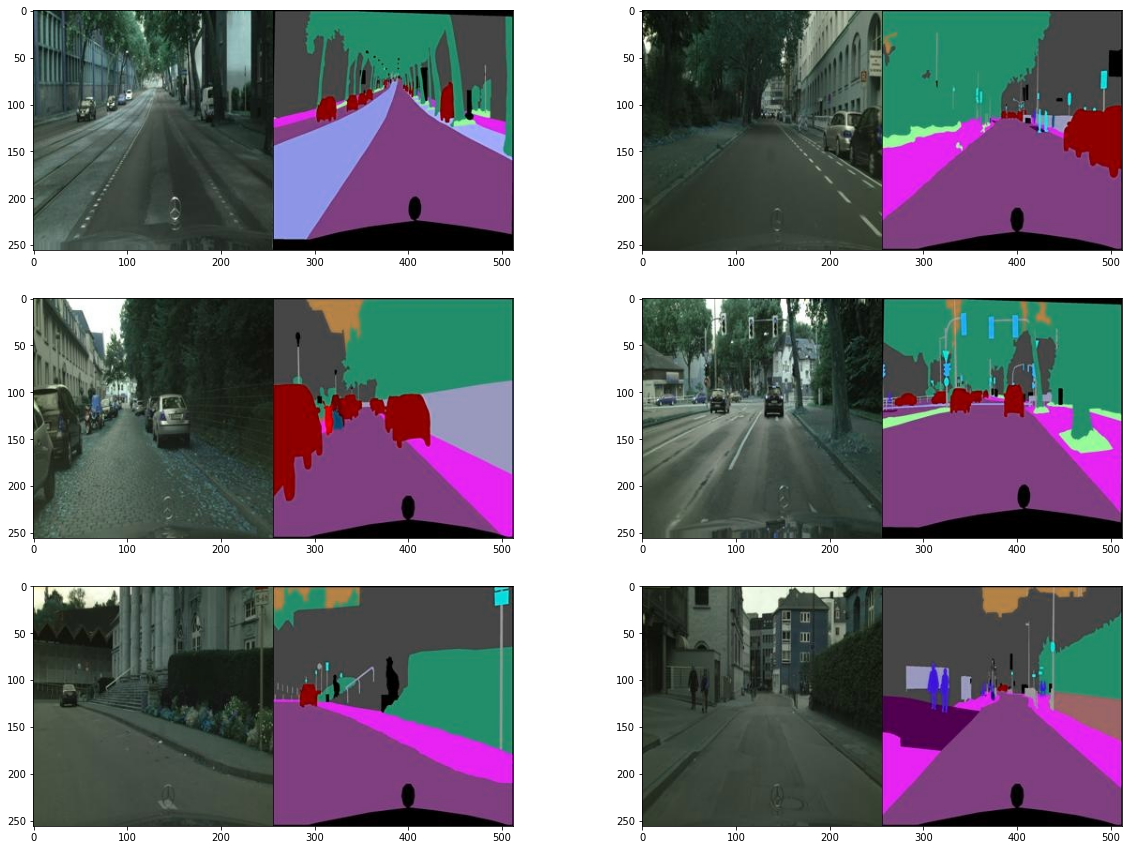

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape) 

(256, 512, 3)


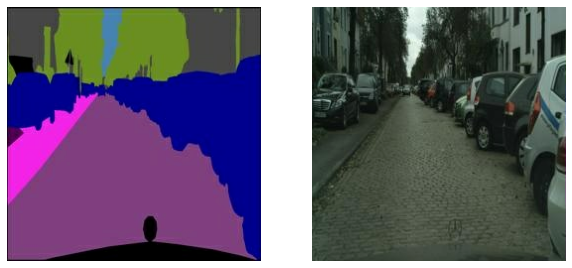

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    original = img[:, :w, :] 
    original = tf.cast(original, tf.float32)
    segmented = img[:, w:, :] 
    segmented = tf.cast(segmented, tf.float32)
    return normalize(original), normalize(segmented)

f = data_path + os.listdir(data_path)[20]
original, segmented = load_img(f)

plt.figure(figsize=(10,7))

plt.subplot(1,2,1); plt.axis('off'); plt.imshow(denormalize(segmented))
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(denormalize(original))

# 1-2 Data augmentation
- 학습에 사용할 수 있는 데이터는 1000개 뿐이기에, 학습에 사용하는 데이터의 다양성을 높이기 위해 다양한 augmentation 방법을 적용합니다. 
- apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용합니다.
- 우선 segmented 이미지에서 색은 물체 구분에 중요한 요소이기 때문에, 색상은 변경하지 않아야 한다고 판단했습니다. 물체마다 특정한 색상이 대응되기 때문에, 밝기, 채도 변화를 주는 것도 의미가 없다고 판단했습니다. 
- 반면 **좌우반전, 이미지 회전, 이미지 잘라내기**를 통한 augmentation은 의미가 있다고 판단했습니다. 
- 블랙박스는 보통 자동차의 전면부를 곧게 바라보기 떄문에, 이미지 회전은 의미가 없다고 생각했으나, 고민 결과, 블랙박스의 목적 자체가 '사고가 발생했을 때' 증거자료를 확보하는 것이기 때문에, 사고가 난 경우 자동차가 회전할 것을 고려하여 상하반전 및 이미지 회전방식도 augmentation 으로 적절하다고 판단했습니다.

    1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat) 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    2. 1의 결과에 각 50%의 확률로 Reflection padding 또는 symmetric padding이 30픽셀의 pad width 만큼 적용됩니다.(tf.pad)
    3. 2의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
    4. 3의 결과를 50%의 확률로 가로를 뒤집습니다. (tf.image.random_flip_left_right)
    5. 4의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
    6. 5의 결과를 50%의 확률로 회전시킵니다. (tf.image.rot90)



- [tf.pad](https://stackoverflow.com/questions/39210093/regarding-the-correct-way-to-understand-the-result-of-tf-pad)
- [tf.constant](https://www.tensorflow.org/api_docs/python/tf/constant) : Creates a constant tensor from a tensor-like object.

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segmented, original):
    stacked = tf.concat([segmented, original], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "SYMMETRIC")
        #padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


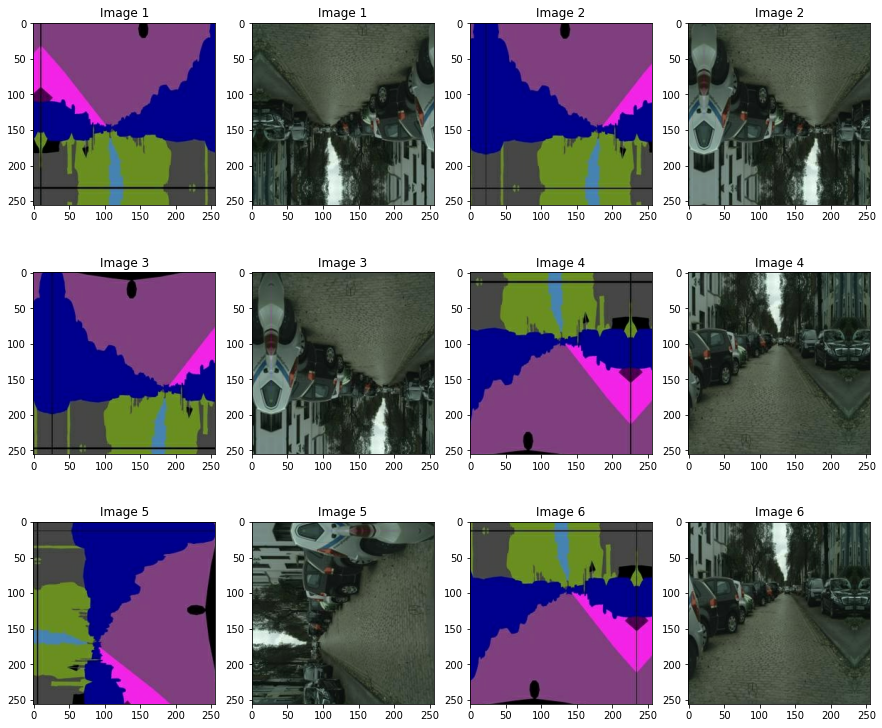

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segmented, augmented_original = apply_augmentation(segmented, original)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segmented)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_original)); plt.title(f"Image {img_n}")
    img_n += 1

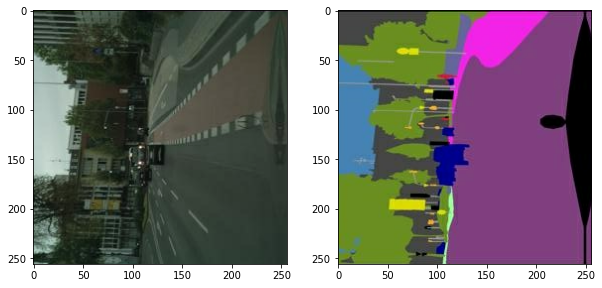

In [7]:
from tensorflow import data

def get_train(img_path):
    segmented, original = load_img(img_path)
    segmented, original = apply_augmentation(segmented, original)
    return segmented, original 

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segmented, original = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segmented[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(original[0].astype(np.uint8))

# 2. Model
# 2-1. U-Net (Generator)
- 단순한 Encoder-Decoder 구조에 비해 **Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과**가 훨씬 더 실제 이미지에 가까운 품질을 보입니다.

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [9]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

# 2-2. PatchGAN(Discriminator)
- 

In [10]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 



class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    


In [11]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

# 3. Train

In [12]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [13]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [14]:
# 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [15]:
#- 학습
EPOCHS = 10 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

step = []
gen_loss = []
nL1_loss = []
Dis_loss = []
for epoch in range(1, EPOCHS+1):
    for i, (segmented, original) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmented, original)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        if (i+1) % 100 == 0:
            step.append(f'{epoch}+{step}')
            gen_loss.append(g_loss.numpy())
            nL1_loss.append(l1_loss.numpy())
            Dis_loss.append(d_loss.numpy())

EPOCH[1] - STEP[10]                     
Generator_loss:0.9178                     
L1_loss:0.2838                     
Discriminator_loss:1.2206

EPOCH[1] - STEP[20]                     
Generator_loss:1.4151                     
L1_loss:0.3092                     
Discriminator_loss:0.8359

EPOCH[1] - STEP[30]                     
Generator_loss:1.5762                     
L1_loss:0.2306                     
Discriminator_loss:0.8371

EPOCH[1] - STEP[40]                     
Generator_loss:1.8621                     
L1_loss:0.2507                     
Discriminator_loss:0.4640

EPOCH[1] - STEP[50]                     
Generator_loss:2.1664                     
L1_loss:0.2567                     
Discriminator_loss:0.4689

EPOCH[1] - STEP[60]                     
Generator_loss:1.8830                     
L1_loss:0.2650                     
Discriminator_loss:0.4486

EPOCH[1] - STEP[70]                     
Generator_loss:2.0157                     
L1_loss:0.2677                    

In [21]:
step

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

loss = pd.DataFrame()
loss['generator']=gen_loss; loss['L1']=nL1_loss; loss['Discriminator']=Dis_loss

def plot_loss(df):
    fig = plt.figure(figsize=(18,6))
    
    ax1.set_title(f'Pix2Pix epoch({step})',size=20, pad=20); 
    ax1.set_xlabel('epochs',size=15)
    ax1.set_ylabel('value',size=15)
    df1.plot(ax=ax1)
    plt.show()
    
compare_BERTs(BERT[acc],pre_BERT[acc],'Accuracy')

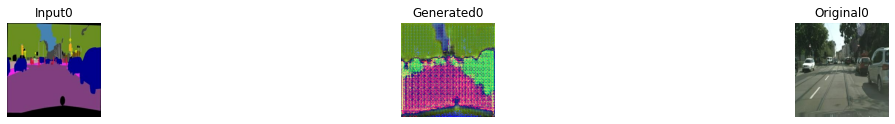

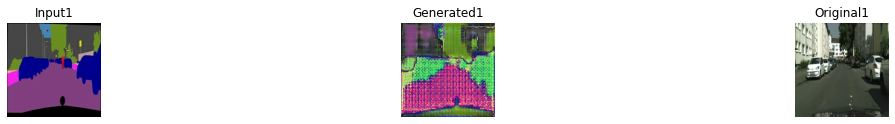

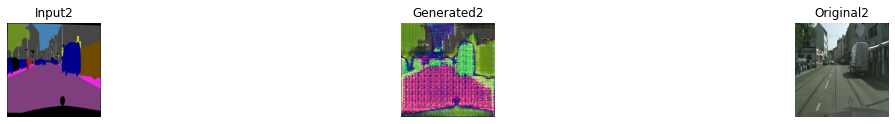

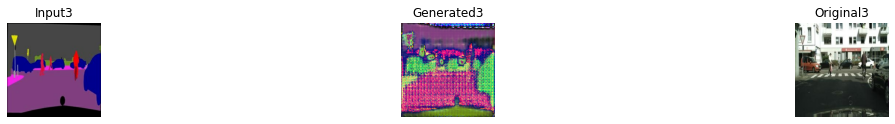

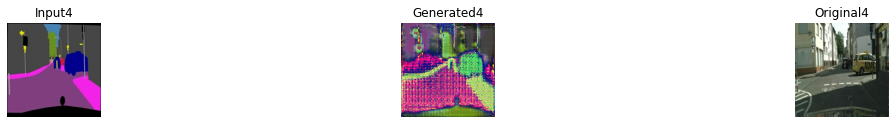

In [20]:
#- 학습해 본 모델에 채색

data_path=os.getenv('HOME')+'/aiffel/Pix2Pix/cityscapes/val/'
num = len(os.listdir(data_path))
for test_idx in range(num):
    
    f = data_path + os.listdir(data_path)[test_idx]

    original, segmented = load_img(f)

    pred = generator(tf.expand_dims(segmented, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(num,3,1); plt.axis('off'); plt.title(f'Input{test_idx}');plt.imshow(denormalize(segmented))
    plt.subplot(num,3,2); plt.axis('off'); plt.title(f'Generated{test_idx}'); plt.imshow(pred[0])
    plt.subplot(num,3,3); plt.axis('off'); plt.title(f'Original{test_idx}'); plt.imshow(denormalize(original))